In this exercise set we inspect the functionality of a neural network in image classification.
1) Get the files that you need:
○ Fetch the Python program CIFAR10-linear.py from the course’s Moodle site under the content block 3 titled ‘Theme 3’ and upload it to a new Google Colab notebook.
○ Fetch the dataset CIFAR10-small from the course’s Moodle site and upload it to the files section of your Colab notebook.
2) After the upload of the dataset has finished, add a new code block to Colab above your CIFAR10-linear code, and type the following command into it: !unzip CIFAR10-small.zip
• Now you can run the code block of CIFAR10-linear. If everything is correct, you will see 5 training epochs and a report of Test loss and Test accuracy in the end
3) Inspect the code block and find answers to the following questions:
○ How many and what types of layers does the neural network of the program have?
○ What is the size of the linear layer of the neural network – number of inputs, number of outputs, weight matrix size?
○ What kind of data normalization is done in the code (Theme 3 slide 87)?
○ How many samples do the training, validation and test sets contain?
4) Change the number of training epochs model.fit to 100 and re-run the code.
○ How is the validation accuracy (val_accuracy) vs. training accuracy (accuracy) at the end of training? What does this tell about the training process?
5) Open the file vis-neurons.py, add a new code block after the last one and enter the code of vis-neurons.py into the new block. Run the new code block – what can you see?
6) Go back to the code block that contains the create_model function. Modify the dense layer in the model so that you add the parameter kernel_regularizer=regularizers.L2(0.03). Re-run the training with 100 epochs, and the re-run the visualization block.
○ How do the output images look like now?
○ How does L2 regularization affect the neural network weights?
○ What is the test accuracy at the end of the training?
7) Add a 2nd dense layer to the neural network, by adding this line above the previous dense layer:
y = Dense(dense_size, activation='relu')(y)
Re-run the training with 100 epochs.
o How is the test accuracy after adding a 2nd layer?
8) Try out the effect of different activation functions to a small 4x4 input matrix: fetch the file activations.py and run the code. Change relu to sigmoid and leaky_relu (negative_slope=0.1), and see how that affects the output.

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras import regularizers
from PIL import Image

def create_model(input_shape, dense_size, classes):
    x = Input(shape=(input_shape))
    y = Flatten()(x)
    y = Dense(classes, activation='softmax', name='dense_layer')(y)
    model = Model(inputs=x, outputs=y)
    return model

def load_labels(filename):
    with open(filename,'r') as file:
       li = file.readlines()
    label_count = len(li)
    labels = np.empty((label_count,1), dtype='int')
    i = 0
    with open(filename) as f:
        for line in f:
            labels[i] = int(line.replace("\n", ""))
            i = i + 1
    return labels

def load_images(folder, image_count, image_size):
    array_shape = (image_count, image_size[0], image_size[1], image_size[2])
    imageset = np.empty(array_shape, dtype='float')
    for i in range(0,image_count):
        image = Image.open(folder + '/image_' + "{:04d}".format(i) + '.png')
        imageset[i] = np.asarray(image)
    return imageset

def normalize_dataset(sampled_images):
	sampled_images = (sampled_images.astype('float32')-128) / 128
	return sampled_images

def split_test_val(data, splitpoint):
    return data[splitpoint:], data[:splitpoint]

########################################################################
Y_test = load_labels('./resources/testing/labels.csv')
X_test = load_images('./resources/testing', len(Y_test), (32,32,3))

y_train = load_labels('./resources/training/labels.csv')
x_train = load_images('./resources/training', len(y_train), (32,32,3))
x_train = normalize_dataset(x_train)

##### Test set preparation #####
splitpoint = 2000
X_test = normalize_dataset(X_test)
x_test, x_val = split_test_val(X_test, splitpoint)
y_test, y_val = split_test_val(Y_test, splitpoint)
print('Validation set size', x_val.shape)
print('Test set size:', x_test.shape)
print('')

class_count = len(np.unique(y_train))

# define a neural network for training
dims = (32, 32, 3)
dense_sz = 100
model = create_model(dims, dense_sz, class_count)

model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Validation set size (2000, 32, 32, 3)
Test set size: (3000, 32, 32, 3)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2205 - loss: 2.1768 - val_accuracy: 0.2850 - val_loss: 2.0402
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3065 - loss: 1.9956 - val_accuracy: 0.3260 - val_loss: 1.9582
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3337 - loss: 1.9267 - val_accuracy: 0.3385 - val_loss: 1.9202
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3508 - loss: 1.8872 - val_accuracy: 0.3575 - val_loss: 1.8939
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3633 - loss: 1.8595 - val_accuracy: 0.3610 - val_loss: 1.8785
Test loss: 1.8517091274261475
Test accuracy: 0.359333336353302


In [19]:
# Page 3 - Model summary and parameter count

weights, biases = model.get_layer('dense_layer').get_weights()

model.summary()

print('Dense layer n. of inputs: ' + str(weights.shape[0]))
print('Dense layer n. of outputs: ' + str(weights.shape[1]))
print('Dense layer n. of weights: ' + str(weights.shape[0]*weights.shape[1]))

# Commented out training part
# model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), metrics=['accuracy'])
# model.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))
# score = model.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer (Dense)             │ (None, 10)             │        30,730 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,192 (360.13 KB)

 Trainable params: 30,730 (120.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,462 (240.09 KB)

Dense layer n. of inputs: 3072
Dense layer n. of outputs: 10
Dense layer n. of weights: 30720


In [20]:
# Page 4 - 100 epochs training
model = create_model(dims, dense_sz, class_count)

weights, biases = model.get_layer('dense_layer').get_weights()

model.summary()

print('Dense layer n. of inputs: ' + str(weights.shape[0]))
print('Dense layer n. of outputs: ' + str(weights.shape[1]))
print('Dense layer n. of weights: ' + str(weights.shape[0]*weights.shape[1]))

model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), metrics=['accuracy'])
model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer (Dense)             │ (None, 10)             │        30,730 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,730 (120.04 KB)

 Trainable params: 30,730 (120.04 KB)

 Non-trainable params: 0 (0.00 B)

Dense layer n. of inputs: 3072
Dense layer n. of outputs: 10
Dense layer n. of weights: 30720
Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1958 - loss: 2.2299 - val_accuracy: 0.2695 - val_loss: 2.0652
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2971 - loss: 2.0030 - val_accuracy: 0.3180 - val_loss: 1.9688
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3323 - loss: 1.9287 - val_accuracy: 0.3350 - val_loss: 1.9241
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3448 - loss: 1.8871 - val_accuracy: 0.3550 - val_loss: 1.8920
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3535 - loss: 1.8590 - val_accuracy: 0.3585 - val_loss: 1.8731
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3649 - loss: 1.8375 - val_accuracy: 0.3660 - val_loss: 1.8595
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3731 - loss: 1.8204 - val_accuracy: 0.3705 - val_loss: 1.8471
Epo

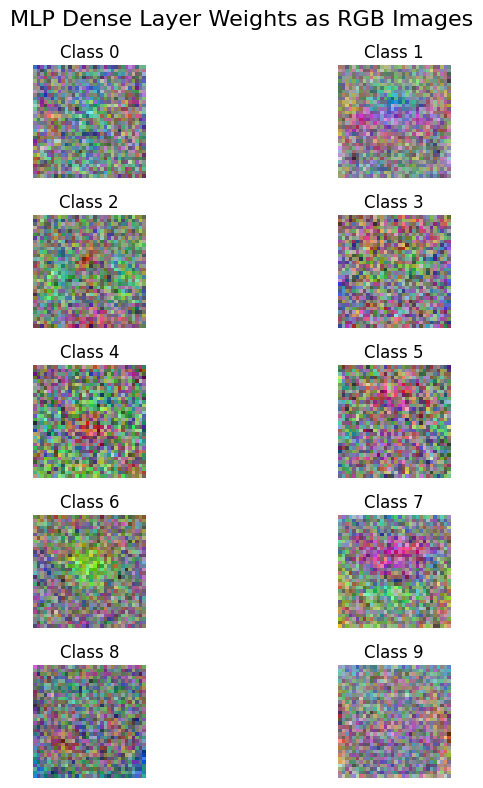

In [21]:
# Page 7 - Visualization of weights + L2 regularization
from matplotlib import pyplot as plt
weights, biases = model.get_layer('dense_layer').get_weights()
height, width, channels = 32, 32, 3
input_shape = (height, width, channels)
fig, axes = plt.subplots(5, 2, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    if i >= weights.shape[1]:
        break
    weight_vector = weights[:, i]
    weight_image = weight_vector.reshape(input_shape)
    min_val = weight_image.min()
    max_val = weight_image.max()
    weight_image = (weight_image - min_val) / (max_val - min_val + 1e-5)  # Avoid division by 0
    ax.imshow(weight_image)
    ax.set_title(f'Class {i}')
    ax.axis('off')
plt.suptitle('MLP Dense Layer Weights as RGB Images', fontsize=16)
plt.tight_layout()
plt.show()

# With L2 regularization
def create_model(input_shape, dense_size, classes):
    x = Input(shape=(input_shape))
    y = Flatten()(x)
    y = Dense(classes, activation='softmax', name='dense_layer', kernel_regularizer=regularizers.L2(0.03))(y)
    model = Model(inputs=x, outputs=y)
    return model

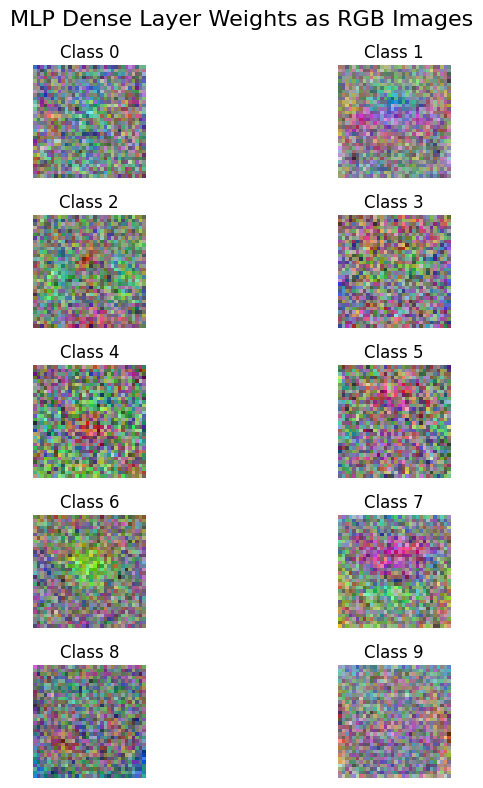

In [23]:
# Visualization of MLP Dense Layer Weights as RGB Images
import matplotlib.pyplot as plt

weights, biases = model.get_layer('dense_layer').get_weights()
height, width, channels = 32, 32, 3
input_shape = (height, width, channels)

fig, axes = plt.subplots(5, 2, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    if i >= weights.shape[1]:
        break
    weight_vector = weights[:, i]
    weight_image = weight_vector.reshape(input_shape)
    min_val = weight_image.min()
    max_val = weight_image.max()
    weight_image = (weight_image - min_val) / (max_val - min_val + 1e-5)  # Avoid division by zero
    ax.imshow(weight_image)
    ax.set_title(f'Class {i}')
    ax.axis('off')

plt.suptitle('MLP Dense Layer Weights as RGB Images', fontsize=16)
plt.tight_layout()
plt.show()